# Semantic matching explains search behavior

In [1]:
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('..')
from src.visualization import utils
utils.setup_matplotlib()

In [2]:
data_split  = 'trainval'
path_maps   = '../data/processed/maps'

scores = {}
for name_maps in ['smm', 'smm_rnd', 'ittikoch', 'deepgaze', 'human']:
    scores[name_maps] = {}
    for name_scores in ['nss', 'auc', 'sauc']:
        scores[name_maps][name_scores] = {}
        with open(f'{path_maps}/{name_maps}/{name_scores}_{data_split}.pkl', 'rb') as f:
            score = pickle.load(f)
        scores[name_maps][name_scores]['tp'] = utils.mns(score['tp'])
        scores[name_maps][name_scores]['ta'] = utils.mns(score['ta'])

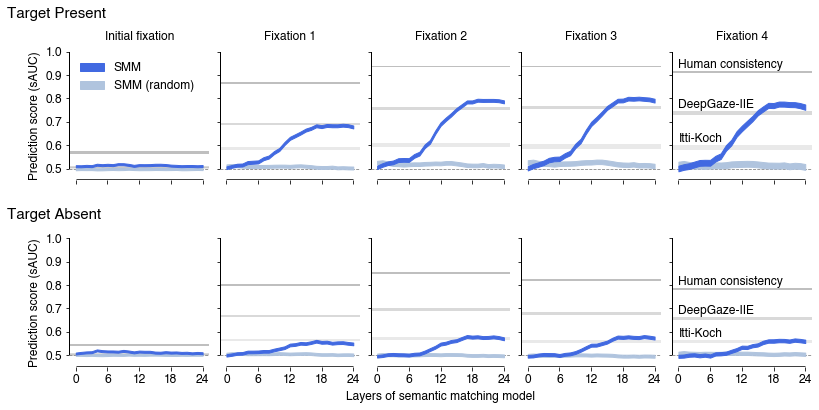

In [3]:
# plot parameters
nm = 'sauc'
chance = 0.5
ylims  = [0.45,1.0]
layers = np.arange(0,25)
scan_orders = [0,1,2,3,4]
os_i, os_d, os_h = 0.012, 0.012, 0.012

f,ax = plt.subplots(2,len(scan_orders),figsize=[13.3,5.8], sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.08, hspace=0.45)
for i in range(len(scan_orders)):
    # SMM
    m_tp, s_tp, m_ta, s_ta = *scores['smm'][nm]['tp'], *scores['smm'][nm]['ta']
    ax[0,i].fill_between(layers, m_tp[i]-s_tp[i], m_tp[i]+s_tp[i], label='SMM', color='royalblue')
    ax[1,i].fill_between(layers, m_ta[i]-s_ta[i], m_ta[i]+s_ta[i], label='SMM', color='royalblue')    
    
    # SMM-random
    m_tp, s_tp, m_ta, s_ta = *scores['smm_rnd'][nm]['tp'], *scores['smm_rnd'][nm]['ta']
    ax[0,i].fill_between(layers, m_tp[i]-s_tp[i], m_tp[i]+s_tp[i], label='SMM (random)', color='lightsteelblue', zorder=-1)
    ax[1,i].fill_between(layers, m_ta[i]-s_ta[i], m_ta[i]+s_ta[i], label='SMM (random)', color='lightsteelblue', zorder=-1)

    # Itti-Koch
    m_tp, s_tp, m_ta, s_ta = *scores['ittikoch'][nm]['tp'], *scores['ittikoch'][nm]['ta']    
    ax[0,i].axhspan((m_tp-s_tp)[i], (m_tp+s_tp)[i], color='darkgray', linewidth=0, alpha=0.25, zorder=-2)
    ax[1,i].axhspan((m_ta-s_ta)[i], (m_ta+s_ta)[i], color='darkgray', linewidth=0, alpha=0.25, zorder=-2)
    if i == 4: 
        ax[0,i].text(0, (m_tp+s_tp)[-1]+os_i, 'Itti-Koch', color='k')
        ax[1,i].text(0, (m_ta+s_ta)[-1]+os_i, 'Itti-Koch', color='k')
    
    # DeepGaze-IIE
    m_tp, s_tp, m_ta, s_ta = *scores['deepgaze'][nm]['tp'], *scores['deepgaze'][nm]['ta']
    ax[0,i].axhspan((m_tp-s_tp)[i], (m_tp+s_tp)[i], color='dimgray', linewidth=0, alpha=0.25, zorder=-2)
    ax[1,i].axhspan((m_ta-s_ta)[i], (m_ta+s_ta)[i], color='dimgray', linewidth=0, alpha=0.25, zorder=-2)
    if i == 4: 
        ax[0,i].text(0, (m_tp+s_tp)[-1]+os_d, 'DeepGaze-IIE', color='k')
        ax[1,i].text(0, (m_ta+s_ta)[-1]+os_d, 'DeepGaze-IIE', color='k')
    
    # Human consistency
    m_tp, s_tp, m_ta, s_ta = *scores['human'][nm]['tp'], *scores['human'][nm]['ta']
    ax[0,i].axhspan((m_tp-s_tp)[i], (m_tp+s_tp)[i], color='k', linewidth=0, alpha=0.25, zorder=-2)
    ax[1,i].axhspan((m_ta-s_ta)[i], (m_ta+s_ta)[i], color='k', linewidth=0, alpha=0.25, zorder=-2)
    if i == 4: 
        ax[0,i].text(0, (m_tp+s_tp)[-1]+os_h, 'Human consistency', color='k')
        ax[1,i].text(0, (m_ta+s_ta)[-1]+os_h, 'Human consistency', color='k')

    # Other
    if i == 0:
        ax[0,i].set_title(f'Initial fixation')
    else:
        ax[0,i].set_title(f'Fixation {i}')
    ax[0,i].axhline(y=chance, linestyle='dashed', color='gray', zorder=-2, linewidth=0.8)
    ax[1,i].axhline(y=chance, linestyle='dashed', color='gray', zorder=-2, linewidth=0.8)

plt.ylim(ylims)
for i in range(5):
    utils.draw_publish_axis(ax[0,i], [0,24], [0.5,1], None, np.linspace(0.5,1.,num=6))
    utils.draw_publish_axis(ax[1,i], [0,24], [0.5,1], [0,6,12,18,24], np.linspace(0.5,1.,num=6))
        
plt.text(0.06, 0.96, 'Target Present', fontsize=15, transform=plt.gcf().transFigure)
plt.text(0.06, 0.48, 'Target Absent',  fontsize=15, transform=plt.gcf().transFigure)
ax[0,0].set_ylabel('Prediction score (sAUC)')
ax[1,0].set_ylabel('Prediction score (sAUC)')
ax[1,2].set_xlabel('Layers of semantic matching model')
ax[0,0].legend(frameon=False, loc='upper left')
plt.savefig(f'{utils.DIR_FIGURE}/fig2.pdf', bbox_inches='tight')
plt.show()